In [1]:
from pathlib import Path
import numpy as np
from datetime import datetime
import xarray as xr

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatch
from matplotlib.transforms import offset_copy

import matplotlib.dates as mdates
import matplotlib.colors as colors
from cartopy.io import shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.geodesic as cgeo
import matplotlib.patches as mpatches
import pandas as pd
import glob
import math

import nbconvert

import itertools
#from matplotlib_scalebar.scalebar import ScaleBar

import cartopy.io.img_tiles as cimgt

from shapely.geometry.polygon import LinearRing


from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose

import gdal
import cmocean
import cmaps

import seaborn as sns
from scipy.stats import norm, frechet_r, gumbel_r, weibull_min, weibull_max
#import skextremes as ske
from sklearn import preprocessing
import statistics

#from sklearn.neighbors import KernelDensity

from matplotlib import style
style.use('fivethirtyeight')

%matplotlib inline

In [2]:
# function to remove outliers from every single along track

def input_files(fname):
    
    #read the data files
    df2 = xr.open_dataset(fname)
    
    #select all the required variables to detect only the valid data
    df2 = df2[['VHM0']]
    
    # convert to pandas dataframe
    df = df2.to_dataframe()
    df.reset_index(inplace=True)


    return df

In [3]:
# import and apply the quality control to all data files

p = Path('C:/Users/panmits86/Dropbox/CMEMS_Wave_Reanalysis')

# iterate the process to every data file
results = []
for fname in p.glob('*.nc'):
    swh_sa = input_files(fname)
    results.append(swh_sa)
    swh_s = pd.concat(results)

In [4]:
ds = xr.open_mfdataset('C:/Users/panmits86/Dropbox/CMEMS_Wave_Reanalysis/global-reanalysis-wav-001-032_24.nc')
x=ds['longitude']
y=ds['latitude']
xx,yy=np.meshgrid(x,y)

<ipython-input-4-a87ac8d59f36>:1: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  ds = xr.open_mfdataset('C:/Users/panmits86/Dropbox/CMEMS_Wave_Reanalysis/global-reanalysis-wav-001-032_24.nc')
C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\xarray\backends\api.py:934: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  combined = auto_combine(


In [5]:
swh_s

,latitude,longitude,time,VHM0
0,42.0,-74.0,1993-01-15 00:00:00,NaN
1,42.0,-74.0,1993-01-15 03:00:00,NaN
2,42.0,-74.0,1993-01-15 06:00:00,NaN
3,42.0,-74.0,1993-01-15 09:00:00,NaN
4,42.0,-74.0,1993-01-15 12:00:00,NaN
...,...,...,...,...
663427,40.0,-70.0,2018-12-25 09:00:00,2.06
663428,40.0,-70.0,2018-12-25 12:00:00,2.14
663429,40.0,-70.0,2018-12-25 15:00:00,1.99
663430,40.0,-70.0,2018-12-25 18:00:00,1.80


In [5]:
buoys = pd.read_excel('buoys.xlsx', header=0, index_col=None, usecols="C:E")
buoys

,Buoys,Longitude,Latitude
0,44097,-71.127,40.969
1,44020,-70.279,41.493
2,44025,-73.164,40.251
3,44017,-72.049,40.693
4,44065,-73.703,40.369
5,44039,-72.655,41.138
6,44040,-73.580,40.956
7,BUZM3,-71.033,41.397


In [6]:
for x,y,z in zip(buoys['Longitude'], buoys['Latitude'], buoys['Buoys']):print(x,y,z)

-71.127 40.969 44097
-70.279 41.493 44020
-73.164 40.251 44025
-72.049 40.693 44017
-73.703 40.369 44065
-72.655 41.138 44039
-73.58 40.956 44040
-71.033 41.397 BUZM3


In [7]:
def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(15, 20),
                           subplot_kw=dict(projection=projection))
    gl = ax.gridlines(draw_labels=True, linestyle='--')
    gl.xlabels_top = False
    gl.xlocator = mticker.FixedLocator([-74, -73.5, -73, -72.5, -72, -71.5, -71, -70.5, -70])
    gl.ylocator = mticker.FixedLocator([40, 40.5, 41, 41.5, 42])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

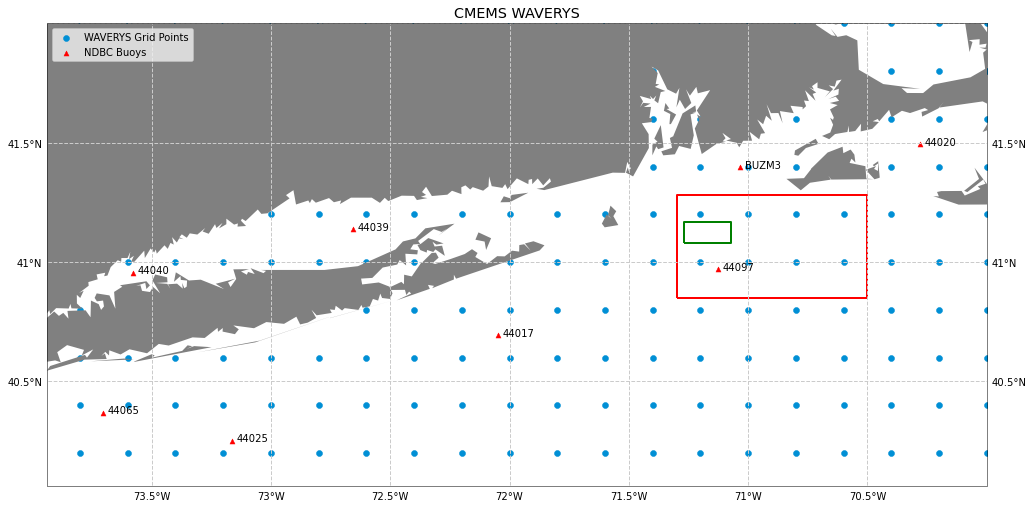

In [8]:
fig, ax = make_map(projection=ccrs.PlateCarree())
ax.set_extent([-73.9375, -70, 40.0625, 42])

shp = shapereader.Reader('C:/Users/panmits86/Desktop/Python/SNE_shapefile/GSHHS_i_L1_SNE.shp')
for record, geometry in zip(shp.records(), shp.geometries()):
    ax.add_geometries([geometry], ccrs.PlateCarree(), facecolor='gray')

"""
# Add markers for the position of the satellite observations.
cmap=cmaps.BlAqGrYeOrRe
bounds = np.array([0,4,8,12,16,20])
#norm = colors.BoundaryNorm(boundaries=bounds, ncolors=10)
norm = mpl.colors.Normalize(vmin=0, vmax=20)
cs2 = plt.pcolormesh(xx, yy, ds['wind_speed'][50], cmap=cmap, norm=norm,
            transform=ccrs.PlateCarree(), shading='flat', snap=True)
cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,aspect=50)
out=fig.colorbar(cs2,cax=cax,ticks=bounds,extend='both',**kw)
out.set_label('Wind Speed (m/s)',size=10)
"""
ax.scatter(xx, yy, label='WAVERYS Grid Points')

lons = [-71.27, -71.27, -71.07, -71.07]
lats = [41.08, 41.17, 41.17, 41.08]

lons_or = [-71.30, -71.30, -70.50, -70.50]
lats_or = [40.85, 41.28, 41.28, 40.85]

lons_gp1 = [-71.3125, -71.3125, -71.0625, -71.0625]
lons_gp2 = [-71.0625, -71.0625, -70.8125, -70.8125]
lons_gp3 = [-70.8125, -70.8125, -70.5625, -70.5625]
lats_gp1 = [40.9375, 41.1875, 41.1875, 40.9375]

ring = LinearRing(list(zip(lons, lats)))
ring_or = LinearRing(list(zip(lons_or, lats_or)))


ax.add_geometries([ring], ccrs.PlateCarree(), facecolor='none', edgecolor='g', linewidth=2, label='Green Area')
ax.add_geometries([ring_or], ccrs.PlateCarree(), facecolor='none', edgecolor='r', linewidth=2, label='Red Area')


ax.scatter(buoys['Longitude'], buoys['Latitude'], s=25, marker='^', color='red', label='NDBC Buoys',transform=ccrs.Geodetic())

for x,y,z in zip(buoys['Longitude'], buoys['Latitude'], buoys['Buoys']):
    ax.text(x+0.02, y+0.01, z,
                 verticalalignment='center', horizontalalignment='left', fontsize=10,
                 transform=ccrs.Geodetic())
    
    """
LegendElement = [mpatches.Patch(facecolor='none', edgecolor='g', linewidth=2, label='Green Area'),
                mpatches.Patch(facecolor='none', edgecolor='r', linewidth=2, label='Red Area'), label='NDBC Buoys']
"""
#plt.arrow(-71.4375, 40.8125, -71.1875, 41.0625, color='k', transform=ccrs.PlateCarree())

#ax.legend(handles = LegendElement, loc='upper left')
ax.legend(loc='upper left')

ax.set_title('CMEMS WAVERYS')
plt.savefig('SNE_CMEMS_wave_gp.png', dpi=300, bbox_inches='tight')